<a href="https://colab.research.google.com/github/MunSikPark/Python_ML_Image_TF/blob/main/05_Image_Detection_1_Korean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fast R-CNN & Faster R-CNN
### 텐서플로를 활용한 Faster R-CNN 실습

이번 세션에서는 직접 데이터 세트를 만들거나 학습하지 않고 텐서플로를 활용해 사전 학습된 모델을 다운로드하여 실행합니다.

git을 활용하여 저장소를 현재 작업 디렉토리에 복제 한다.
--depth 1 옵션은 저장소의 전체 이력을 복제하는 대신가장최근의 커밋만 복제 합니다. 이를 통해 저장소의 사이즈를 줄이고 다운로드 속도를 빠르게 할 수 있습니다.

github.com/tensorflow/models는 텐서플로의공식 모델 저장소 주소입니다. 이 저장소에는 다양한 텐서프롤 모델과 예제 그리고 Object Detection API 관련 코드들이 포함되어 있습니다.

In [ ]:
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 4301, done.
remote: Counting objects: 100% (4301/4301), done.
remote: Compressing objects: 100% (3286/3286), done.
remote: Total 4301 (delta 1211), reused 2200 (delta 943), pack-reused 0 (from 0)
Receiving objects: 100% (4301/4301), 52.93 MiB | 17.01 MiB/s, done.
Resolving deltas: 100% (1211/1211), done.


프로토콜 버퍼 (PROTOCOL BUFFERS)는 구글에서 개발한 직렬화 데이터 구조로, 텐서플로 Object Detection API에서는 이르 ㄹ사용하여 구성 파일을 관리 합니다. 그래서 컴파일하기 위한 컴파일러를 설치합니다. 그리고 현재 디렉토리에 파이썬용 .py데이터 들이 설치되게됩니다. 이를 통해 Objective Detection API 관련된 필요한 패키지와 모듈들이 시스템에 설치 됩니다.

In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.12.4-1ubuntu7.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━

#1 label_map_util은 레이블 맵을 처리하기 위한 유틸리티 입니다. 레이블 맵은 각가의 탐지된 객체 클래스에 대한 ID와 이름을 매핑합니다. ex '1: dog', '2: cat'
#2 visualization_utils는 객체 탐지 결과를 이미지 위에 시각화하기 위한 유틸리티입니다. 이를통해 탐지된 객체주위에 경계 상자, 바운딩박스, 를 그리고 클래스 이름과 점수를 표시 합니다.
#3 Ops는 Object Detection API 에서 필요한 다양한 연선과 관련된 유틸리티 함수들을 포함하고 있습니다.

In [ ]:
from object_detection.utils import label_map_util # 1
from object_detection.utils import visualization_utils as viz_utils # 2
from object_detection.utils import ops as utils_ops # 3
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
%matplotlib inline

아래는 이제 레이블 맵을 로드하고 텐서플로 허브에서 Faster R-CNN 모델을 가져오는 코드입니다
MSCOCO 데이터 세트에 대한레이블 맵의 경로를 지정합니다. MSCOCO 는 대표적인 객체 탐지 데이터 세트 중 하나로 많은 사전 학습된 모델이 이 데이터 세트를 기반으로 학습되었습니다. mscoco_label_map.pbtxt 파일은각 객체 카테고리의 ID와 이름을 정의합니다.
다음으로 label_map_util.create_category_index_from_labelmap()을 사용하여 지정된경로의 레이블 맵 파일을 읽어서카테고리 키를 생성합니다. 이 인덱스는 후에 탐지된 객체의 클래스 ID를 실제이름으로 변환화는데 사용됩니다.

이어서 hub.load()를 사용하여 텐세플로허브에서 모델을 다운로드하고 로드합니다. 여기서는 Faster R-CNN 모델을 ResNet-50 아키텍처와 함께 사용하며, 입력 이미지의 사이즈는640 * 640 으로 설정되어 있습니다. /1은모델의 버전을 의미합니다.

이제 hub_model 변수에 로드된 모델을 사용하여 이미지에 대한 객체 탐지를 수행하고, category_index를 활용하여 탐지된 객체의 클래스 ID를 실제 이름으로 변환 할 수 있습니다.

In [ ]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
hub_model = hub.load('https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1')

아래처럼, cv2를 활용하여 이미지를 불러온 후, 텐서플로 모델에 넣기 위해 이미지를 한 번 더 리스트로 감싼 후 np.array를 사용하여 텐서 형태로 만들어 줍니다.



In [ ]:
!wget https://raw.githubusercontent.com/Lilcob/test_colab/main/three%20young%20man.jpg
image_path = '/content/three young man.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_np = np.array([image])

--2024-10-13 06:46:50--  https://raw.githubusercontent.com/Lilcob/test_colab/main/three%20young%20man.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146736 (143K) [image/jpeg]
Saving to: ‘three young man.jpg’

three young man.jpg 100%[===================>] 143.30K  --.-KB/s    in 0.004s  

2024-10-13 06:46:50 (31.2 MB/s) - ‘three young man.jpg’ saved [146736/146736]



다음 코드는 사전 학습된 Faster R-CNN 모델을 사용하여 이미지(image_np)에 대한 객체 탐지를 수행하고, 결과를 시각화하기 위한 준비 과정을 나타냅니다.

1번 로드된 Faster R-CNN 모델을 사용하여 이미지에 대한 객체 탐지를 수행합니다. 결과는 여러 가지 정보 (예를들어 탐지된 객체의 경계 상자, 클래스 ID, 점수 등)를 포함하는 딕셔너리 형태로 반한됩니다. result 부분은 텐서플로의 tensor 형식에서 일반 numpy 배열로 변환 합니다. 이렇게 변환된 결과는 후속 처리와 시각화에 더 유용하게 사용됩니다.

2번 label_id_offset는 클래스 ID 오프셋입니다. 일반적으로 MSCOCO 데이터 세트에서는 0을 사용합니다.

In [ ]:
results = hub_model(image_np) # 1
result = {key: value.numpy() for key, value in results.items()}
print(result.keys())

label_id_offset = 0 # 2
image_np_with_detections = image_np.copy()

dict_keys(['detection_anchor_indices', 'raw_detection_boxes', 'raw_detection_scores', 'detection_classes', 'detection_boxes', 'detection_multiclass_scores', 'num_detections', 'detection_scores'])


다음으로 코드로 탐지 결과를 이미지 위에 시각화합니다. 이 과정으로 탐지된 객체의 경계 상자, 클래스 ID, 그리고 점수를 이미지에 표시하여 결과를 직관적으로 확인할 수 있게 해줍니다.



*   image_np_with_detections[0]: 시각화 할 이미지 입니다.
*   result['detection_boxes'][0]: 탐지된 객체의 경계 상자 정보 입니다.
*   (result['detection_classes'][0] + label_id_offset).astype(int): 탐지된 객체의 클래스 id 입니다. label_id_offset을 추가하고 정수형으로 반환합니다.
*   result['detection_scores'][0]: 탐지된 객체의 신뢰도 점수입니다.
*   category_index: 클래스 ID와 클래스 이름을 매핑한 딕셔너리 입니다.
*   use_normalized_coordinates=True: 경계 상자가 정규화되었음을 나타냅니다.
*   max_boxes_to_draw=200: 이미지 위에 표시할 최대 경계 상자 수 입니다.
*   min_score_thresh=.30: 이값보다 낮은 신뢰도 점수를 가진 객체는 시각화에서 제외됩니다.
*   agnostic_mode=False: 클래스를 무시하고 모든 객체를 동일한 색상으로 표시할지의 여부입니다.

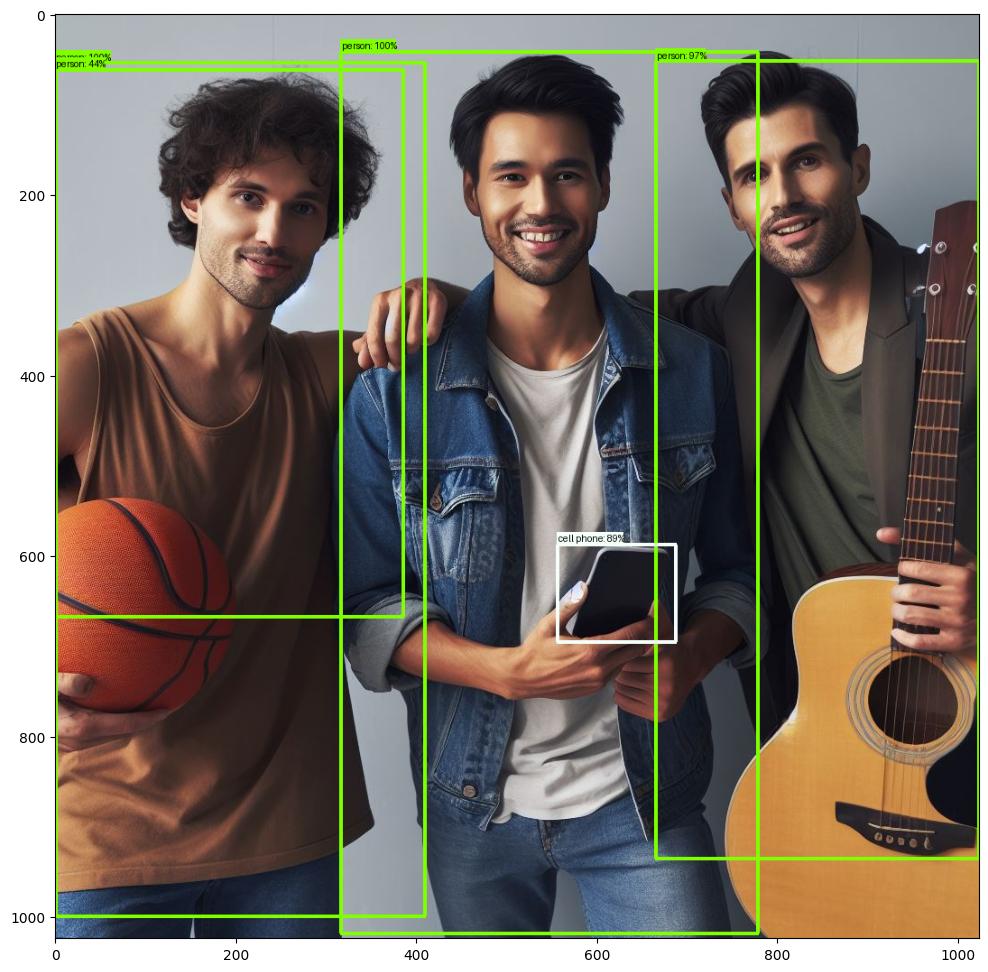

In [ ]:
viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections[0],result['detection_boxes'][0],
(result['detection_classes'][0] + label_id_offset).astype(int),
 result['detection_scores'][0],category_index,use_normalized_coordinates=True, max_boxes_to_draw=200,min_score_thresh=.30,
agnostic_mode=False)
plt.figure(figsize=(12, 12))
plt.imshow(image_np_with_detections[0])
plt.show()


객체 탐지 분야는 여기서 멈추지 않았습니다. two-stage detector는 높은 정확도를 제공하지만, 처리 속도 측면에서는 한계가 있었습니다. 이를 개선하기 위해 탄생한 것이 one-stage detector입니다.



One-stage detector는 처리 속도를 중시하면서도 탐지 정확도를 유지하려는 노력의 결과물로, 실시간 객체 탐지와 같은 응용분야에서 중요한 역할을 하고 있습니다. 이를 통해 객체 탐지의 다양한 방법론과 그 발전 과정에 대해 더욱 깊게 이해할 수 있을 것입니다.

## one-stage-detector
#### YOLO

You Only Look Once: 이미지를 한 번만 처리하여 객체의 위치와 해당 객체의 클래스를 동시에 예측합니다. 대표적인 알고리즘 YOLO. 전통적인 탐지 방법과는 대조적으로, 복잡한 파이프라인이나 여러 단게의 처러ㅣ 없이 이미지를 실시간으로 분석할 수 있게 해줍니다. 이로 인해 YOLO는 실시간 처리가 필요한 응용분야에서 매우 유용하게 사용 될 수 있습니다.

본격적으로 YOLO 객체 탐지를 구현하기 전에, 먼저 사용할데이터 세트에 대한 이해와 준비가 필요합니다. 데이터 세트는 모델 학습의 기반이 되기 때문에 그 중요성은 말할 것도 없습니다. PASCAL VOC 2007 을 사용 할 것입니다.

PASCAL VOC 2007은 다양한 물체와 상황에서 촬영된 이미지들로 구성되어 있으며, 각 이미지는 물체의 위치와 클래스 정보를 포함하는 주석이 함께 제공됩니다. 이를 통해 모델은 물체의 위치와 클래스를 동시에 예측하도록 학습됩니다.

아래 코드는 PASCAL VOC 2007 데이터 세트를 다운로드하고, 알맞게 폴더를 구성하여 압축을 해제하는 과정입니다. 마지막으로 XML 주석을 파싱하는 데 도움을 주는 xmltodict 라이브러리를 설치합니다. 이 데이터 세트 위에서 YOLO의 성능을 직접 확인해 보겠습니다.

In [ ]:
!wget -N http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar \
      http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
!mkdir -p VOCtrainval_2007 VOCtest_2007
!tar -xvf VOCtrainval_06-Nov-2007.tar -C VOCtrainval_2007/
!tar -xvf VOCtest_06-Nov-2007.tar -C VOCtest_2007/
!pip install xmltodict


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
VOCdevkit/VOC2007/JPEGImages/000736.jpg
VOCdevkit/VOC2007/JPEGImages/000737.jpg
VOCdevkit/VOC2007/JPEGImages/000741.jpg
VOCdevkit/VOC2007/JPEGImages/000743.jpg
VOCdevkit/VOC2007/JPEGImages/000744.jpg
VOCdevkit/VOC2007/JPEGImages/000745.jpg
VOCdevkit/VOC2007/JPEGImages/000747.jpg
VOCdevkit/VOC2007/JPEGImages/000749.jpg
VOCdevkit/VOC2007/JPEGImages/000751.jpg
VOCdevkit/VOC2007/JPEGImages/000757.jpg
VOCdevkit/VOC2007/JPEGImages/000758.jpg
VOCdevkit/VOC2007/JPEGImages/000759.jpg
VOCdevkit/VOC2007/JPEGImages/000762.jpg
VOCdevkit/VOC2007/JPEGImages/000765.jpg
VOCdevkit/VOC2007/JPEGImages/000766.jpg
VOCdevkit/VOC2007/JPEGImages/000769.jpg
VOCdevkit/VOC2007/JPEGImages/000773.jpg
VOCdevkit/VOC2007/JPEGImages/000775.jpg
VOCdevkit/VOC2007/JPEGImages/000778.jpg
VOCdevkit/VOC2007/JPEGImages/000779.jpg
VOCdevkit/VOC2007/JPEGImages/000781.jpg
VOCdevkit/VOC2007/JPEGImages/000783.jpg
VOCdevkit/VOC2007/JPEGImages/000784.jpg
VOCdevkit/VOC2007/JPEGImages/000785.jpg
VOCd

In [ ]:
import numpy as np             # 배열 연산을 위한 라이브러리
import cv2                     # 이미지 처리를 위한 OpenCV 라이브러리
import xmltodict               # XML 파싱을 위한 라이브러리
from tqdm import tqdm          # 진행 상황 표시를 위한 라이브러리
import tensorflow as tf        # 딥러닝 프레임워크 텐서플로우
from glob import glob          # 파일 경로들을 리스트로 불러오는 라이브러리
from tensorflow.keras.callbacks import ModelCheckpoint    # 모델 중간 저장을 위한 콜백입니다.

!wget https://raw.githubusercontent.com/Cobslab/imageBible/main/image/like_lenna224.png -O like_lenna.png # 테스트용 이미지를 다운로드합니다.

--2024-10-13 06:47:59--  https://raw.githubusercontent.com/Cobslab/imageBible/main/image/like_lenna224.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30283 (30K) [image/png]
Saving to: ‘like_lenna.png’

like_lenna.png      100%[===================>]  29.57K  --.-KB/s    in 0s      

2024-10-13 06:47:59 (84.8 MB/s) - ‘like_lenna.png’ saved [30283/30283]



In [ ]:
# 파일 경로 설정
train_x_path='/content/VOCtest_2007/VOCdevkit/VOC2007/JPEGImages'
train_y_path='/content/VOCtrainval_2007/VOCdevkit/VOC2007/Annotations'
test_x_path='/content/VOCtest_2007/VOCdevkit/VOC2007/JPEGImages'
test_y_path='/content/VOCtest_2007/VOCdevkit/VOC2007/Annotations'


아래에서 glob 함수를 사용하여 지정된 경로에서 모든 파일의 경로를 시스트 형태로 가져옵니다. 데이터 세트의 사이즈가 크므로 전체 데이터의 약 70만을 사용하여 실험의 효율성을 높입니다. 테스트 데이터에 대해서도 동일한 작업을 수행합니다. 이렇게 준비된 이미지와 주석 파일의 경로를 바탕으로, 이후의 과정에서 데이터를 불러와 모델의 학습 및 테스트에 사용합니다.

In [ ]:
# 학습 데이터의 이미지와 XML 파일 경로를 획득합니다.
image_file_path_list = sorted([x for x in glob(train_x_path + '/**')])
subset_size = len(image_file_path_list) // 70  # 전체 데이터의 약 1/70만 사용
image_file_path_list = image_file_path_list[:subset_size]
xml_file_path_list = sorted([x for x in glob(train_y_path + '/**')])
xml_file_path_list = xml_file_path_list[:subset_size]

# 테스트 데이터의 이미지와 XML 파일 경로를 획득합니다.
test_image_file_path_list = sorted([x for x in glob(test_x_path + '/**')])
subset_size = len(test_image_file_path_list) // 70  # 전체 데이터의 약 1/70만 사용
test_image_file_path_list = test_image_file_path_list[:subset_size]
test_xml_file_path_list = sorted([x for x in glob(test_y_path + '/**')])
test_xml_file_path_list = test_xml_file_path_list[:subset_size]


VOC 데이터 세트 내에 어떤 클래스의 객체들이 있는지 파악하는 것은 중요합니다. 코드는 이러한 기능을 제공하기 위해 작성되었습니다. 함수 get_Classes_inimage는 VOC 데이터 세트의 XML 주석 파일들 중 객체 클래스를 분석하여 리스트로 반환합니다.

각 XML 파일을 순회하며 해당 파일을 읽습니다. xmltodict 라이브러리를 사용하여 XML 형식의 내용을 파이썬의 딕셔너리 형태로 변환합니다. 각 XML 파일은 해당 이미지에 대한 주석 정보를 담고 있습니다. 이미지에 포함된 객체들의 정보가 주석으로 기록되어 있으며, 이 정보 중 객체의 클래스 이름(name)을 추출합니다.

XML 주석 중, 하나의 이미지에 여러 객체가 포함된 경우와 단 하나의 객체만 포함된 경우를 구분하여 처리합니다. 여러 객체가 포함된 경우 각 객체의 정보를 순회하며 클래스 이름을 가져오고, 단일 객체만 있는 경우에는 바로 해당 객체의 클래스 이름을 가져옵니다.

이렇게 추출된 클래스 이름들은 Classes_inDataSet 리스트에 추가됩니다. 후에 중복된 클래스 이름을 제거하고 알파벳순으로 정렬하여 출력합니다. 정리된 클래스 목록은 후에 모델 학습이나 데이터 전처리 등에서 사용 될 수 있습니다.

In [ ]:
def get_classes_in_image(xml_file_list):
    classes_in_data_set = set()

    for xml_file_path in xml_file_list:
        with open(xml_file_path, 'r') as file:
            xml_file = xmltodict.parse(file.read())

            objects = xml_file['annotation']['object']

            # 항상 리스트 형태로 처리하기 위해 단일 객체도 리스트로 변환
            if not isinstance(objects, list):
                objects = [objects]

            for obj in objects:
                classes_in_data_set.add(obj['name'].lower())

    classes_in_data_set = sorted(classes_in_data_set)
    print(classes_in_data_set)
    return classes_in_data_set
classes_inDataSet = get_classes_in_image(test_xml_file_path_list)


['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


다음은 VOC 데이터 세트에서 이미지에 대한 레이블을 추출하고 전처리하는 코드 입니다. 이 함수는 주어진 XML 파일에서 객체의 좌표를 읽어와, 모델이 사용할 수 있는 형식으로 변환합니다.

get_label_fromImage 함수는 주어진 XML 파일 경로와 데이터 세트 내의 클래스 목록을 입력으로 사용하여 해당 이미지에 대한 레이블을 반환합니다. (1)

함수 내에는 transform_coordinates라는 내부함수가 정의되어 있으며 (2), 이 함수는 주어진 좌표와 이미지의 너비 및 높이를 사용하여 해당 좌표를 (224,224) 사이즈의 이미지에 맞게 조정합니다(3). 그 후에 해당 좌표를 사용하여 객체의 중심 좌표와 너비, 높이를 계산합니다.

XML 파일은 파싱되어 사전 객체로 변환되며(4), 이미지의 너비와 높이 정보를 가져옵니다. 함수는 7*7 그리드와 25개의 채널을 갖는 레이블 배열을 0으로 초기화합니다(5). 이 배열은 YOLO 알고리즘에서 사용되는 레이블 형식을 나타냅니다. XML 파일에서 객체 정보를 가져와 각 객체의 클래스 인덱스와 경계 상자 좌표를 찾습니다(6). 그 후 transform_coordinates 함수를 사용하여 이 좌표를 조정하고, 객체의 중심이 속한 그리드 셀의 좌표와 그 셀 내에서의 상대적인 위치를 계산합니다(7). 이 정보와 클래스 정보를 사용하여 레이블 배열에 저장합니다. 마지막으로 완성된 레이블 배열에 반환됩니다.

In [ ]:
def get_label_fromImage(xml_file_path, Classes_inDataSet): # (1)
    def transform_coordinates(coordinates, Image_Width, Image_Height): # (2)
        x_min, y_min, x_max, y_max = coordinates
        x_min, x_max = [(224.0 / Image_Width) * x for x in [x_min, x_max]]
        y_min, y_max = [(224.0 / Image_Height) * y for y in [y_min, y_max]]
        x, y, w, h = (x_min + x_max) / 2.0, (y_min + y_max) / 2.0, (x_max - x_min) / 224.0, (y_max - y_min) / 224.0 # (3)
        return x, y, w, h

    with open(xml_file_path, 'r') as f:
        xml_file = xmltodict.parse(f.read()) # (4)

    Image_Height, Image_Width = float(xml_file['annotation']['size']['height']), float(xml_file['annotation']['size']['width'])
    label = np.zeros((7, 7, 25), dtype=float) # (5)

    objects = xml_file['annotation']['object']
    if not isinstance(objects, list): objects = [objects]

    for obj in objects:
        class_index = Classes_inDataSet.index(obj['name'].lower()) # (6)
        coordinates = float(obj['bndbox']['xmin']), float(obj['bndbox']['ymin']), float(obj['bndbox']['xmax']), float(obj['bndbox']['ymax'])
        x, y, w, h = transform_coordinates(coordinates, Image_Width, Image_Height) # (7)
        x_cell, y_cell = int(x / 32), int(y / 32)
        x_val_inCell, y_val_inCell = (x - x_cell * 32.0) / 32.0, (y - y_cell * 32.0) / 32.0
        class_index_inCell = class_index + 5
        label[y_cell, x_cell, :5] = [x_val_inCell, y_val_inCell, w, h, 1.0]
        label[y_cell, x_cell, class_index_inCell] = 1.0

    return label


그 다음 데이터 세트를 만드는 과정을 진행합니다.

make_dataset 함수는 이미지 파일 경로 목록, XML 파일 경로 목록, 그리고 데이터 세트 내의 클래스 목록을 입력으로 받아, 이미지와 레이블의 테이트 세트를 생성합니다. 내부에 process_image 함수가 정의되어 있어 주어진 이미지 파일 경로로부터 이미지를 읽고, (224, 224)로 리사이즈한 후, 픽셀 값을 0과 1사이로 정규화합니다. (1)

이후에 이미지 파일 경로 목록을 순회하며 process_image 함수를 사용해 이미지 데이터 세트를 생성합니다(②) 동일하게 XML 파일 경로 목록을 순회하며 get_label_fromImage 함수를 사용하 여 레이블 데이터 세트를 생성합니다(③).

생성된 이미지와 레이블 데이터 세트는 numpy 배열로 변환되며, 특히 레이블 데이터 세트는 적절한 모양으로 재구성됩니다(④) 함수의 마지막에서는 이미지 데이터 세트와 텐서플로 텐서 형식으로 변환된 레이블 데이터 세트를 반환합니다. 이 함 수를 사용해 훈련용과 테스트용 이미지 및 레이블 데이터 세트를 생성합니다.


In [ ]:
def make_dataset(image_file_path_list, xml_file_path_list, Classes_inDataSet):

    def process_image(image_file_path): # (1)
        image = cv2.imread(image_file_path)
        return cv2.resize(image, (224, 224)) / 255.0

    image_dataset = [process_image(image_path) for image_path in tqdm(image_file_path_list, desc="Processing images")] # (2)
    label_dataset = [get_label_fromImage(xml_path, Classes_inDataSet) for xml_path in tqdm(xml_file_path_list, desc="Processing labels")] # (3)

    image_dataset = np.array(image_dataset, dtype=np.float32)
    label_dataset = np.array(label_dataset, dtype=np.float32).reshape(-1, 7, 7, 25) # (4)

    return image_dataset, tf.convert_to_tensor(label_dataset)

train_image_dataset, train_label_dataset = make_dataset(image_file_path_list,xml_file_path_list,classes_inDataSet)
test_image_dataset, test_label_dataset = make_dataset(test_image_file_path_list,test_xml_file_path_list,classes_inDataSet)


Processing labels: 100%|██████████| 70/70 [00:00<00:00, 1711.48it/s]


이제 모델을 설계해보겠습니다. 다음 코드는 모델의 학습 시간을 고려하여 VGG16 아키텍처를 활용하여 YOLO 모델을 구축하는 작업을 수행합니다.

코드의 시작 부분에서는 VGG16 모델에서 사용된 층의 전체 개수를 max_num 변수에 저장합니다. 이 값을 사용하여 VGG16의 모든 층을, 최상위 층을 제외하고, 새로운 Sequential 모델인 YOLO 에 추가합니다(①) 이렇게 함으로써 YOLO 모델의 기본 구조를 VGG16의 구조로 초기 설정합니 다. 다음으로 초기화 방식을 정의합니다. initializer는 가중치를 초기화하는 데 사용되는 방식 으로, 여기서는 평균이 0이고 표준 편차가 0.01인 정규 분포로 설정됩니다. '이 초기화 방식은 신 경망의 학습 속도와 수렴을 개선하는 데 도움을 줍니다(②).

LeakyReLU 활성화 함수도 정의됩니다. LeakyReLU는 음수 값에 대해 작은 기울기를 갖는 활성화 함수로, 신경망에서 일반적인 ReLU의 '죽은 뉴런' 문제를 해결하는 데 도움을 줍니다(③).

또한 L2 규제(또는 릿지 규제라고도 함)를 정의하여 신경망의 가중치가 너무 큰 값을 갖지 않도록 제한합니다. 이렇게 하면 과적합을 방지하고 모델의 일반화 성능을 향상시킬 수 있습니다.


마지막으로 YOLO 모델의 모든 층을 순회하면서 두 가지 작업을 수행합니다(④).

첫째, 각 층의 학습 가능성을 False로 설정하여, 사전 학습된 가중치가 학습 중에 변경되지 않게 합니다.


둘째, 해당 중에 활성화 함수가 있는 경우, 그 활성화 함수를 LeakyReLU로 변경합니다. 이는 Y OLO 모델에서 더 나은 성능을 달성하기 위해 사용되는 특정 기술입니다.

이제 모델 작성 코드를 간소화하기 위하여 중 생성 함수를 작성하고 증을 모델에 추가해보겠습니 다.

In [ ]:
# 모델 설계
max_num = len(tf.keras.applications.VGG16(weights='imagenet', include_top=False,  input_shape=(224, 224, 3)).layers) # 1
YOLO = tf.keras.models.Sequential(name = "YOLO")
for i in range(0, max_num-1):
    YOLO.add(tf.keras.applications.VGG16(weights='imagenet', include_top=False,  input_shape=(224, 224, 3)).layers[i])

initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None) # 2
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.01) # 3
regularizer = tf.keras.regularizers.l2(0.0005)

# Activation function 바꾸는 부분이 잘 안되어서 나중에 다시 확인해 봐야 한다

#for layer in YOLO.layers: #4
#    layer.trainable=False
#    if (hasattr(layer,'activation'))==True:
#        layer.activation = leaky_relu

첫 번째 단계에서는 합성곱 증을 추가하는 작업을 간단하게 만들기 위해 add_conv_layer 함수를 정의했습니다. 이 함수는 필터의 개수, 층의 이름 등 필요한 매개변수를 받아서 합성곱 증을 모델 에 추가합니다. 여기서는 LeakyReLU 활성화 함수, 특정 초기화 방식, 규제 방식을 동일하게 적용 하며 중을 추가합니다.

두 번째 단계에서는 밀집증을 추가하는 작업을 간소화하기 위한 add_dense_layer라는 도우미 함 수를 정의합니다. 이 함수는 중에 사용될 유닛의 수, 이름, 활성화 함수, 그리고 선택적으로 드름 아웃 비율을 인수로 받아 밀집증을 모델에 추가합니다.

이후 앞에서 정의한 함수들을 사용하여 모델에 여러 개의 합성곱 중과 완전 연결 중을 추가합니 다 특히, 최대 풀링 중도 중간에 추가되어 이미지의 공간적 차원을 줄입니다.

마지막으로 출력층의 형태를 (7,7,30)으로 재구성하기 위한 Reshape 층을 추가합니다. 이 형태는 YOLO 모델의 특성상 각 그리드 셀에 대한 예측 값을 나타냅니다.

In [ ]:
def add_conv_layer(YOLO, filters, name):
    YOLO.add(tf.keras.layers.Conv2D(filters, (3, 3),activation=leaky_relu,kernel_initializer=initializer,kernel_regularizer=regularizer,padding='SAME',name=name,dtype='float32'))

def add_dense_layer(YOLO, units, name, activation=leaky_relu, dropout=None):
    YOLO.add(tf.keras.layers.Dense(units,activation=activation,kernel_initializer=initializer,kernel_regularizer=regularizer,name=name,dtype='float32'))
    if dropout:
        YOLO.add(tf.keras.layers.Dropout(dropout))

# 모델에 층 추가
add_conv_layer(YOLO, 1024, "detection_conv1")
add_conv_layer(YOLO, 1024, "detection_conv2")
YOLO.add(tf.keras.layers.MaxPool2D((2, 2)))
add_conv_layer(YOLO, 1024, "detection_conv3")
add_conv_layer(YOLO, 1024, "detection_conv4")

# 밀집 층 추가
YOLO.add(tf.keras.layers.Flatten())
add_dense_layer(YOLO, 4096, "detection_linear1", dropout=0.5)
add_dense_layer(YOLO, 1470, "detection_linear2", activation=None)

# 결과 구조 재배열
YOLO.add(tf.keras.layers.Reshape((7, 7, 30), name='output', dtype='float32'))

이 함수는 주어진 실제 값과 예측된 값을 바탕으로 모델의 성능을 평가하는 역할을 합니다. 첫 번 째 단계에서는 각 샘플에 대한 손실 값을 계산하기 위해 y_true와 y_pred의 각 항목을 반복합니 다. 이때 주어진 데이터를 49×25와 49×30의 형태로 재구성합니다(①). 그다음 단계에서는 각셀 의 실제 값과 예측된 값을 바탕으로 손실을 계산합니다(②). 여기서 핵심은 각 셀에 대한 여러 손 실 구성 요소를 계산하는 것입니다. 이러한 요소에는 바운딩 박스의 위치, 물체의 존재에 대한 확 신 정수, 그리고 클래스 예측에 대한 오차가 포함됩니다(③, ④ ③) 그 후에는 loU(Intersection over Union)를 계산하는 함수를 정의하여 두 개의 예측된 바운딩 박스 중 어느 것이 실제 바운딩 박스와 더 가까운지 판단합니다(⑥) 이 정보를 바탕으로 위치 손실, 확신 점수 손실, 그리고 클래스 손실 을 계산하게 됩니다(⑦), 모든 셀의 손실 값을 합산한 후 전체 배치의 평균 손실을 반환합니다(⑧) 이 결과 값은 모델의 학습 과정 중에 사용되어, 예측 성능을 최적화하는 데 도움을 줍니다.

다음으로 하이퍼파라미터 설정 및 모델 학습을 진행해보겠습니다.

In [ ]:
# 손실 함수 정의
def yolo_multitask_loss(y_true, y_pred):

    batch_loss = 0

    for true_vals, pred_vals in zip(y_true, y_pred):
        true_vals = tf.reshape(true_vals, [49, 25]) # 1
        pred_vals = tf.reshape(pred_vals, [49, 30]) # 1
        cell_losses = []
        for true_cell, pred_cell in zip(true_vals, pred_vals):
            bbox1_pred, bbox1_pred_confidence, bbox2_pred, bbox2_pred_confidence, class_pred = \
                pred_cell[:4], pred_cell[4], pred_cell[5:9], pred_cell[9], pred_cell[10:]
            bbox_true, bbox_true_confidence, class_true = \
                true_cell[:4], true_cell[4], true_cell[5:] # 2

            def calculate_iou(bbox_pred, bbox_true): # 3

                pred_area = bbox_pred[2] * bbox_pred[3]
                true_area = bbox_true[2] * bbox_true[3]

                pred_minmax = [bbox_pred[0] - 0.5*bbox_pred[2], bbox_pred[1] - 0.5*bbox_pred[3],
                               bbox_pred[0] + 0.5*bbox_pred[2], bbox_pred[1] + 0.5*bbox_pred[3]]

                true_minmax = [bbox_true[0] - 0.5*bbox_true[2], bbox_true[1] - 0.5*bbox_true[3],
                               bbox_true[0] + 0.5*bbox_true[2], bbox_true[1] + 0.5*bbox_true[3]]

                inter_xy_min = tf.maximum(pred_minmax[:2], true_minmax[:2])
                inter_xy_max = tf.minimum(pred_minmax[2:], true_minmax[2:])

                inter_area = tf.maximum(0.0, inter_xy_max[0] - inter_xy_min[0]) * \
                             tf.maximum(0.0, inter_xy_max[1] - inter_xy_min[1])
                union_area = pred_area + true_area - inter_area
                return inter_area / union_area
            iou_bbox1 = calculate_iou(bbox1_pred, bbox_true)
            iou_bbox2 = calculate_iou(bbox2_pred, bbox_true)
            responsible_bbox = bbox1_pred if iou_bbox1 > iou_bbox2 else bbox2_pred # 4
            responsible_bbox_confidence = bbox1_pred_confidence if iou_bbox1 > iou_bbox2 else bbox2_pred_confidence # 4
            non_responsible_bbox_confidence = bbox2_pred_confidence if iou_bbox1 > iou_bbox2 else bbox1_pred_confidence # 4
            obj_exist = 1.0 - tf.cast(tf.reduce_all(tf.equal(bbox_true, 0.0)), tf.float32)

            localization_err = tf.reduce_sum(tf.square(bbox_true - responsible_bbox)) * obj_exist # 5
            confidence_err_obj = tf.square(responsible_bbox_confidence - bbox_true_confidence) * obj_exist # 5
            confidence_err_noobj = 0.5 * tf.square(non_responsible_bbox_confidence) * (1.0 - obj_exist) # 5
            classification_err = tf.reduce_sum(tf.square(class_true - class_pred)) * obj_exist # 5

            cell_loss = 5.0 * localization_err + confidence_err_obj + confidence_err_noobj + classification_err # 6
            cell_losses.append(cell_loss)

        batch_loss += tf.reduce_sum(cell_losses) # 7

    batch_loss /= tf.cast(tf.shape(y_true)[0], tf.float32) # 8
    return batch_loss

초기 설정으로 BATCH_SIZE는 64로 설정되었고(①), 총 훈련 에포크 수는 120으로 지정되었습니 다(②) 또한 훈련 중에 가장 좋은 성능의 모델을 저장하기 위해 yolo.hs라는 파일 이름을 사용하 게 됩니다(③)

학습률 스케줄링을 위한 1r_schedule 함수를 통해 에포크에 따라 학습률을 조절합니다(②). 처음 75 에포크 동안은 학습률이 0.001에서 시작하여 0.01까지 선형적으로 증가하며(③), 다음 30에 포크(75-105 에포크) 동안은 학습률을 0.001로 유지합니다(⑥) 마지막 30 에포크에서는 학습률 을 0.0001로 낮줍니다(⑦). 이러한 스케줄링은 모델이 초기에는 큰 학습률로 빠르게 학습하고, 점 차 학습률을 줄여서 수렴을 도와주는 방식입니다.

compile_and_train_model 함수는 모델을 컴파일하고 훈련하는 역할을 합니다(⑧). 이 함수 내에 서 확률적 경사 하강법 옵티마이저와 초기 학습률 0.001, 그리고 모멘텀 0.9를 사용하여 모델을 컴파일합니다() 또한 훈련 중 가장 낮은 손실 값을 가진 모델의 가중치를 yolo.h5 파일에 저장 하기 위해 콜백을 설정합니다(⑨) 학습률 스케줄링도 콜백으로 구현되어, 각 에포크마다 lr_sche dule 함수를 통해 학습률을 조절합니다(10)

마지막으로 compile_and_train_model 함수를 사용하여 YOLO 모델을 훈련 데이터와 검증 데이 터로 훈련시킵니다(12).

이제 객체 검출 알고리즘의 출력을 처리하고 결과를 이미지에 그려서 시각화해보겠습니다.

In [ ]:
BATCH_SIZE = 64 # 1
EPOCHS = 120 # 2
SAVE_PATH = 'yolo.keras' # 3

def lr_schedule(epoch): # 4
    if epoch < 75:
        return 0.001 + 0.001 * (epoch / 75.0) # 5
    elif epoch < 105:
        return 0.001 # 6
    else:
        return 0.0001 # 7

def compile_and_train_model(model, train_data, val_data): # 8
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        SAVE_PATH,
        verbose=1,
        save_best_only=True # 9
    )

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule) # 10

    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9) # 11
    model.compile(loss=yolo_multitask_loss, optimizer=optimizer, run_eagerly=True)

    model.fit(
        train_data[0], train_data[1],
        batch_size=BATCH_SIZE,
        validation_data=val_data,
        epochs=EPOCHS,
        verbose=1,
        callbacks=[checkpoint_callback, lr_callback]
    )
compile_and_train_model(YOLO, (train_image_dataset, train_label_dataset), (test_image_dataset, test_label_dataset))

이미지의 기본 사이즈와 그리드 셀의 사이즈를 전역 상수로 설정합니다(①, ②) convert_to_corn er_coordinates 함수는 바운딩 박스의 중심 좌표를 사용하여 모서리 좌표로 변환합니다(③) 이 는 이미지에 박스를 그리는 작업을 단순화하기 위함입니다. process_single_bbox 함수는 주어진 그리드 셀 위치와 바운딩 박스 정보를 기반으로, 해당 박스의 모서리 좌표, 최고 클래스 점수, 그 리고 해당 클래스의 이름을 반환합니다(④). nms 함수는 바운딩 박스 목록을 받아 threshold(기본 값은 0.6)보다 높은 클래스 점수를 가진 박스만을 반환합니다(③) 주요 함수인 get_YOLO_output 은 YOLO 모델, 이미지 경로, 그리고 클래스 이름 목록을 입력으로 받습니다. 이 함수는 이미지를 불러오고, YOLO 모델을 사용하여 예측을 수행한 후, 그 결과를 바탕으로 객체를 감지하고 이미 지에 그립니다() 마지막으로 결과 이미지를 output.jpg로 저장합니다.

코드를 실행하면 다음처럼 출력됩니다.

In [ ]:
IMAGE_SIZE = (224, 224) # 1
CELL_SIZE = 32 # 2

def convert_to_corner_coordinates(x, y, bbox, image_size): # 3
    bbox_x = (CELL_SIZE * x + bbox[0] * CELL_SIZE) * image_size[0] / IMAGE_SIZE[0]
    bbox_y = (CELL_SIZE * y + bbox[1] * CELL_SIZE) * image_size[1] / IMAGE_SIZE[1]
    bbox_w = bbox[2] * image_size[0]
    bbox_h = bbox[3] * image_size[1]

    min_x = int(bbox_x - bbox_w/2)
    min_y = int(bbox_y - bbox_h/2)
    max_x = int(bbox_x + bbox_w/2)
    max_y = int(bbox_y + bbox_h/2)

    return [min_x, min_y, max_x, max_y]

def process_single_bbox(x, y, bbox, image_size, classes_score, class_names): # 4
    idx_highest_score = np.argmax(classes_score)
    highest_score = classes_score[idx_highest_score]
    highest_score_name = class_names[idx_highest_score]

    corner_coords = convert_to_corner_coordinates(x, y, bbox, image_size)

    return corner_coords + [highest_score, highest_score_name]

def nms(bbox_list, threshold=0.6): # 5
    return [bbox for bbox in bbox_list if bbox[4] > threshold]

def get_YOLO_output(YOLO, image_path, class_names): # 6
    image_cv = cv2.imread(image_path)
    original_h, original_w, _ = image_cv.shape
    image_resized = cv2.resize(image_cv, IMAGE_SIZE) / 255.0
    image_input = np.expand_dims(image_resized, axis=0).astype('float32')

    yolo_output = YOLO(image_input)[0].numpy()

    bbox_list = []
    for y in range(7):
        for x in range(7):
            bbox1 = yolo_output[y][x][:4]
            bbox2 = yolo_output[y][x][5:9]
            bbox1_score = yolo_output[y][x][10:] * yolo_output[y][x][4]
            bbox2_score = yolo_output[y][x][10:] * yolo_output[y][x][9]

            bbox1_processed = process_single_bbox(x, y, bbox1, (original_w, original_h), bbox1_score, class_names)
            bbox2_processed = process_single_bbox(x, y, bbox2, (original_w, original_h), bbox2_score, class_names)

            bbox_list.extend([bbox1_processed, bbox2_processed])

    nms_boxes = nms(bbox_list)

    for bbox in nms_boxes:
        cv2.rectangle(image_cv, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)

    cv2.imwrite('output.jpg', image_cv)

In [ ]:
get_YOLO_output(YOLO,'/content/like_lenna.png',classes_inDataSet)

## YOLO v3

DarkNet-19

DarkNet-19는 YOLO v2 또는 YOLO9000이라고도 불리는 버전에서 사용된 특징 추출을 위한 딥 러닝 아키텍처입니다. 이 아키텍처의 이름에서 알 수 있듯이, 주요 구성은 19개의 중으로 이루어 져 있습니다. DarkNet-19는 고성능 객체 검출기를 타깃으로 설계되었기 때문에 성능 최적화와 연 산 효율성에 중점을 둔다는 점이 특징입니다.

특징 피라미드 네트워크를 이용한 멀티 스케일 예측

YOLO v1의 큰 단점으로 여겨지던 부분 중 하나는 바로 작은 사이즈를 가진 객체의 탐지 능력이 기존 two-stage detector에 비해 떨어진다는 점이었습니다. YOLO v3에서는 기존 단점을 커버하 는 멀티 스케일 예측 성능을 올리기 위한 다양한 방법론을 제안합니다. 모델의 전체적인 흐름에 대해 살펴보겠습니다.

DarkNet 환경을 설정하고 YOLO 객체 탐지 모델을 준비하는 과정을 단계별로 설명합니다. 먼저 *cd/content 명령을 사용하여 작업 디렉터리를/content로 변경합니다. 다음으로, !rm -rf dar knet 명령으로 기존에 존재할 수 있는 darknet 폴더를 삭제해서 새로운 설치를 위한 공간을 마련 합니다.

이어서 !git clone https://github.com/pjreddie/darknet 명령으로 깃허브에서 pjreddie의 'da rknet 저장소를 복제합니다. 'darknet'은 YOLO 객체 탐지 모델을 구현하는 데 사용되는 오픈 소 스 신경망 프레임워크입니다. 복제가 완료된 후 %cd darknet 명령으로 'darknet' 폴더로 작업 디 렉터리를 변경합니다. 그 후 make 명령을 실행하여 'darknet'을 빌드합니다.

이 과정에서 소스 코드를 컴파일하고 실행 가능한 파일을 생성합니다. 빌드가 완료되면 ! ls -al darknet 명령으로 darknet 풀더 내의 파일들을 나열하여 빌드가 성공적으로 이루어졌는지 확인 할 수 있습니다. 마지막으로!./darknet 명령을 실행하여 빌드된 'darknet' 실행 파일을 테스트합 니다. 이러한 단계를 거치면 YOLO 객체 탐지 모델을 사용할 준비가 완료되며, 이를 통해 이미지 나 비디오 내의 객체를 탐지하고 분류할 수 있게 됩니다.

그러고 나면 다음 코드로 YOLO v3 객체 탐지 모델의 사전 훈련된 가중치를 다운로드합니다.

In [ ]:
%cd /content
!rm -rf darknet
!git clone https://github.com/pjreddie/darknet
%cd darknet
!make
!ls -al darknet
!./darknet

/content
Cloning into 'darknet'...
remote: Enumerating objects: 5955, done.
remote: Total 5955 (delta 0), reused 0 (delta 0), pack-reused 5955 (from 1)
Receiving objects: 100% (5955/5955), 6.37 MiB | 20.27 MiB/s, done.
Resolving deltas: 100% (3932/3932), done.
/content/darknet
mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/gemm.c -o obj/gemm.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/utils.c -o obj/utils.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/cuda.c -o obj/cuda.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/convolutional_layer.c -o obj/co

코드의 각 부분은 다음과 같은 기능을 수행합니다.

• %cd/content/darknet: 이 명령은 현재 작업 디렉터리를 /content/darknet으로 변경합니다. 이 디렉터리는 앞서 복제한 'darknet' 저장소가 위치한 곳으로, YOLO v3 모델을 실행하기 위 한 환경을 설정합니다.

• wget https://pjreddie.com/media/files/YOLO v3.weights: wget 명령은 웹에서 파일을 다 운로드하는 데 사용됩니다. 여기서는 YOLO v3의 원저자인 PJ Reddie의 웹 사이트에서 사전 훈련된 YOLO v3 가중치 파일을 다운로드합니다. 이 가중치 파일은 YOLO v3 모델이 이미 다 양한 객체를 탐지하도록 훈련되었음을 의미하며, 이를 통해 별도의 훈련 과정 없이 바로 객체 탐지 작업을 수행할 수 있습니다.

이 과정을 통해 YOLO v3 모델을 사용할 준비를 완료하고, 실제 이미지나 비디오에 대한 객체 탐 지를 수행할 수 있습니다. 사전 훈련된 가중치를 사용하면, 복잡한 훈련 과정 없이도 빠르고 효율 적으로 객체 탐지를 할 수 있으며, 이는 특히 리소스가 제한적인 환경이나 실시간 처리가 필요한 응용에서 유용합니다.

다음으로, YOLO v3 객체 탐지 모델을 사용하여 주어진 이미지에서 객체를 탐지하고, 탐지 결과 를 보여주는 과정을 수행합니다..

In [ ]:
%cd /content/darknet
!wget https://pjreddie.com/media/files/yolov3.weights

/content/darknet
--2024-10-13 07:12:08--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  10.5MB/s    in 18s     

2024-10-13 07:12:27 (13.3 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



각 단계의 역할은 다음과 같습니다.

• %cd/content/darknet 이 명령은 현재 작업 디렉터리를 /content/darknet으로 변경합니다. 이는 YOLO v3 모델과 관련 파일들이 있는 darknet 물더로 이동하는 것입니다.

• !./darknet detect cfg/TOLO v3.cfg YOLO v3.weights data/dog.jpg 이 명령은 사전 훈련 YOLO V3 모델을 사용하여 'data/dog jpg 이미지 파일에 대한 각제 탐지를 수행합니다. 여 기서 dg/YOLO v3 dg는 모델의 구성 파일, YOLO v3 weights는 사전 훈련된 가중치 파일을 나타냅니다. 이 명령은 이미지에서 격제를 탐지하고, 탐지 결과(객체의 위치, 클래스 등)를 edictions. jpg 파일로 저장합니다.

• from IPython.display Import Image: 이 코드는 파이썬에서 이미지를 표시하기 위한 라이브 러리를 가져옵니다.

• Image('predictions.jpg') 이 명령은 predictions jpg 이미지 파일을 노트북에서 직접 표시 합니다. 이 파일에는 YOLO v3 모델이 탐지한 객체와 그 위치, 클래스 이름이 표시되어 있습니다.

이 코드를 실행하면 YOLO V3 모델이 어떻게 작동하는지 직접 볼 수 있으며, 실제 이미지에서 객 제 탐지가 어떻게 이루어지는지 확인할 수 있습니다. 이는 YOLO v3의 능력을 직접 체험하고, 실 제 응용에 적용할 수 있는 방법을 이해하는 데 도움이 됩니다.

이제 우리는 EfficientDET으로 넘어끌 것입니다. EfficentDET은 컴퓨터 비전 분야에서 객체 참지 기술의 발전을 한 단계 더 끌어올린 모델입니다. 최근 몇 년간의 할지 모델의 눈부신 발전은 새로 운 신경망 아키텍처와 알고리즘의 도입에 힘입은 것이며, EfficientDET은 이러한 진보를 대표하 는 예시 중 하나입니다. 이 모델은 효율성과 정확도의 균형을 잘 잡으면서도, 다양한 사이즈와 형 태의 객제를 효과적으로 탐지할 수 있는 능력을 갖추고 있습니다. 다음 철에서는 EfficentDET의 구조와 작동 원리, 그리고 이 모델이 컴퓨터 비전 분야에서 어떻게 중요한 역할을 하고 있는지 자 세히 살펴보겠습니다.

/content/darknet
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8      

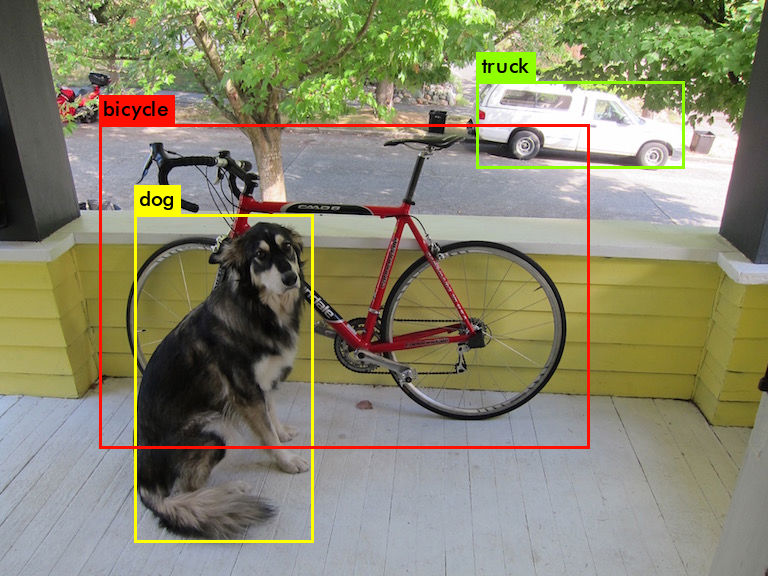

In [ ]:
%cd /content/darknet
!./darknet detect cfg/yolov3.cfg yolov3.weights data/dog.jpg

from IPython.display import Image
Image('predictions.jpg')

컴퓨터 비전 분야에서의 객체 탐지 기술은 지난 몇 년동안 눈부신 발전을 이루어왔습니다. 이분 야의 성장은 주로 새로운 신경망 아키텍처와 알고리즘의 발전에 기인합니다. 특히 이피션트넷과 EfficientDET은 이러한 발전에서 중요한 역할을 하는 기술들로, 객체 탐지의 정확도와 효율성을 혁신적으로 개선하였습니다.

현대의 객제 탐지 모델들은 고도로 정교한 아키텍처로 구성되어 있습니다. 이들의 구조는 크게 세 부분으로 나누어를 수 있습니다.

ㆍ백본 네트워크(backbone network): 모델의 기본 구조로, 입력 이미지에서 기본적인 특징들을 추 출하는 역할을 합니다. 백본 네트워크는 일반적으로 깊은 신경망으로 구성되어 있으며, 이미 지 내의 다양한 시각적 패턴을 학습합니다.

·특징 추출 피라미드 네트워크 Pyramid Network, FPN): FPN은 백본 네트워크에서 추출한 특징 맵의 정보를 다양한 스케일에서 통합합니다. 이러한 통합은 모델이 이미지의 다양한 사 이즈와 형태의 객체를 효과적으로 탐지하도록 돕습니다.

·예측 네트워크(Prediction Network): 이 부분은 통합된 피쳐 맵을 바탕으로 최종 객체 탐지를 수행 합니다. 여기에는 객체의 위치, 사이즈, 클래스 등을 예측하는 다양한 중과 메커니즘이 포함 됩니다.

이피션트넷은 4장에서 소개된 것처럼 딥러닝 분야에서 높은 효율성과 성능을 제공하는 신경망 구조로, 이는 뛰어난 정확도와 네트워크 효율성을 동시에 달성합니다. 이러한 특성은 이피션트넷 을 객체 탐지, 이미지 분류 등 다양한 컴퓨터 비전 작업에 이상적인 백본 네트워크로 만듭니다.

EfficientDET은 이러한 이피션트넷의 원칙을 객체 탐지 분야에 적용합니다. EfficientDET은 이피 션트넷을 백본 네트워크로 사용하며, 이를 통해 높은 정확도와 효율성을 달성합니다. 특히 Efficie ntDET은 네트워크의 여러 중에서 추출된 특징 맵을 효율적으로 사용하여 다양한 사이즈의 객체 를 정확하게 탐지합니다. 이는 객체 탐지에 있어서 중요한 성능 향상을 의미하며, 특히 자원이 제 한된 환경에서 응용 가능하다는 큰 장점이 있습니다.

이피션트넷과 EfficientDET의 결합은 컴퓨터 비전 분야에서의 혁신적인 발전을 대표합니다. 이 기술들은 객체 탐지의 정확도와 속도를 크게 향상시키며, 실시간 이미지 처리, 모바일 애플리케 이션, 클라우드 서비스 등 다양한 분야에서의 응용 가능성을 열어줍니다. 이제 EfficientDET의 구 조와 작동 방식에 대해 더 자세히 살펴보겠습니다.

In [ ]:
%cd /content
!rm -rf darknet
!git clone https://github.com/pjreddie/darknet
%cd darknet
!make
!ls -al darknet
!./darknet
%cd /content/darknet
!wget https://pjreddie.com/media/files/yolov3.weights

/content
Cloning into 'darknet'...
remote: Enumerating objects: 5955, done.
remote: Total 5955 (delta 0), reused 0 (delta 0), pack-reused 5955 (from 1)
Receiving objects: 100% (5955/5955), 6.37 MiB | 20.65 MiB/s, done.
Resolving deltas: 100% (3932/3932), done.
/content/darknet
mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/gemm.c -o obj/gemm.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/utils.c -o obj/utils.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/cuda.c -o obj/cuda.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/convolutional_layer.c -o obj/co

/content/darknet
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8      

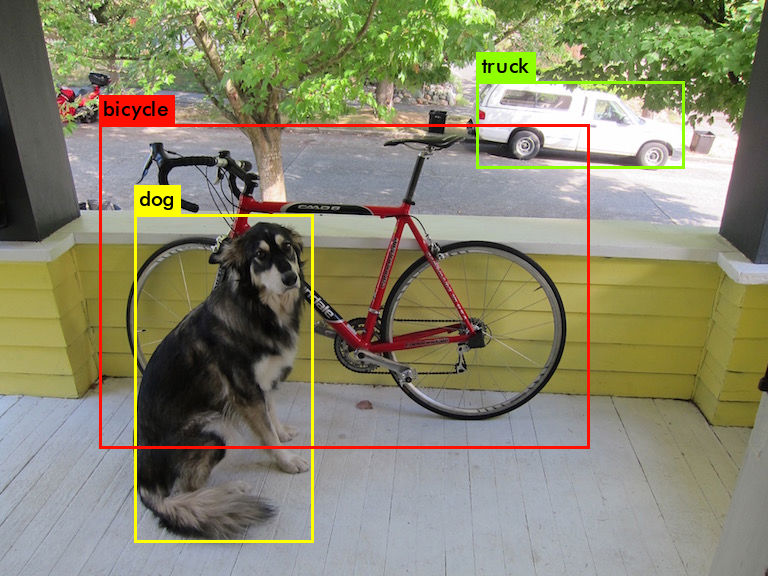

In [ ]:
%cd /content/darknet
!./darknet detect cfg/yolov3.cfg yolov3.weights data/dog.jpg

from IPython.display import Image
Image('predictions.jpg')


## EfficientDET 실습

텐서플로를 활용한 EfficientDET 실습

 지금까지는 EfficientDet의 이론적인 부분을 살펴보았습니다. 이를 바탕으로 EfficientDet을 구현 하는 코드를 살펴볼 차례입니다. 특별히 이번엔 텐서플로 라이트(Tensorflow Lite)를 사용하여 Efficie ntDET 모델을 구현하는 방법을 살펴볼 것입니다. 텐서플로 라이트는 텐서플로의 경량화 버전으 로, 모바일 및 임베디드 디바이스에서 머신 러닝 모델을 효율적으로 실행할 수 있도록 설계되었 습니다.

먼저 다음처럼 필요한 라이브러리를 불러옵니다.

이미지 처리와 배열 연산을 수행하기 위해 OpenCV와 NumPy를 불러오고, 텐서플로 및 텐서플로 허브 라이브러리도 불러옵니다. 그다음 텐서플로 허브를 통해 EfficientDET 모델을 불러옵니다 (①). 이 모델은 URL을 통해 다운로드되며, 텐서플로 라이트 버전의 EfficientDET 모델을 가져옵 니다. 해당 모델은 가볍고 모바일 및 임베디드 기기에서 실행하기에 적합하도록 최적화되어 있습 니다. hub. Load 코드로 모델을 불러오며 뒤 코드에서 탐지를 수행하는 데 사용됩니다. 추가로 테 스트할 이미지도 함께 받아주겠습니다(②).

이제 탐지된 객체의 클래스 ID를 사람이 읽을 수 있는 이름으로 변환하기 위한 레이블 매핑을 정 의합니다.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
import time
model = hub.load("https://tfhub.dev/tensorflow/efficientdet/lite0/detection/1") # 1
!wget https://github.com/Cobslab/imageBible/blob/main/image/test_image.png?raw=true -O test_image.png

--2024-10-13 13:30:29--  https://github.com/Cobslab/imageBible/blob/main/image/test_image.png?raw=true
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Cobslab/imageBible/raw/refs/heads/main/image/test_image.png [following]
--2024-10-13 13:30:30--  https://github.com/Cobslab/imageBible/raw/refs/heads/main/image/test_image.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Cobslab/imageBible/refs/heads/main/image/test_image.png [following]
--2024-10-13 13:30:30--  https://raw.githubusercontent.com/Cobslab/imageBible/refs/heads/main/image/test_image.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.

객체 탐지를 수행할 때 반환되는 클래스 ID와 실제 객체 이름 사이의 매핑을 정의합니다. 사전 학 습 때 사용한 객체로, 객체 이름과 고유한 ID로 식별됩니다. 이 매핑은 모델이 탐지한 객체의 ID를 사람이 읽을 수 있는 이름으로 변환하는 데 사용됩니다.

이제 다음 코드를 사용하여 이미지 내의 객체를 탐지하고, 탐지된 객체에 대한 정보를 이미지 위 에 표시하는 과정을 수행합니다.

In [ ]:
labels_mapping = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

detect_objects 함수는 텐서플로 라이트의 EfficientDET 모델을 사용하여 이미지에서 객체를 탐 지하고, 탐지된 객체에 대한 정보를 이미지 위에 표시하는 기능을 수행합니다(①) 함수는 model, ing array, threshold, max objects, print_time 매개변수를 받습니다.

함수의 주요 작업은 다음과 같습니다.

·입력된 이미지 배열(img_array)의 복사본을 생성합니다(②) 이 복사본에 탐지된 객체에 대한 정보를 그릴 것입니다.

ㆍ이미지 배열을 텐서플로의 텐서로 변환하고, 모델에 입력하기 위해 적절한 형태로 변환합니 다(3)

·모델을 사용하여 이미지에서 객체 탐지를 수행합니다. 이때 모델은 객체의 위치(박스), 점수, 클래스, 탐지된 객체의 수를 반환합니다(4)

· 탐지된 각 객체에 대해, 설정된 임계 값(threshold) 이상의 정수를 가진 객체만 처리합니다 (5).

· 탐지된 객체의 위치 정보(박스 좌표)를 사용하여 이미지에 사각형을 그리고, 객체의 클래스와 점수를 함께 표시합니다. 이때 사각형은 녹색으로, 텍스트는 빨간색으로 표시됩니다(⑥).

•print_time 매개변수가 True로 설정된 경우, 탐지에 소요된 시간을 출력합니다(⑦)

·최종적으로 객체제 정보가 추가된 이미지 복사본을 반환합니다(8).

detect_objects 함수는 EfficientDET 모델의 탐지 결과를 시각적으로 확인할 수 있게 하며, 실제 애플리케이션에서 이미지 내 객체를 식별하고 위치를 파악하는 데 유용하게 사용될 수 있습니다. 또한 텐서플로 라이트 버전으로 실행이 되는 만큼, 어느 정도 짧은 시간 안에 탐지가 가능한지 확 인해보겠습니다.

In [ ]:
def detect_objects(model, img_array, threshold, max_objects=100, print_time=True): #1
    img_copy = img_array.copy() #2
    green = (0, 255, 0)
    red = (0, 0, 255)
    tensor_img = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...] #3
    start = time.time()
    boxes, scores, classes, num_detections = model(tensor_img) # 4
    boxes = boxes.numpy()
    scores = scores.numpy()
    classes = classes.numpy()
    num_detections = num_detections.numpy()

    for i in range(num_detections[0]):
        if scores[0, i] < threshold: # 5
            break
        box = boxes[0, i]
        left, top, right, bottom = box[1], box[0], box[3], box[2]
        class_id = classes[0, i]
        caption = "{}: {:.4f}".format(labels_mapping[class_id], scores[0, i])
        cv2.rectangle(img_copy, (int(left), int(top)), (int(right), int(bottom)), color=green, thickness=2) # 6
        cv2.putText(img_copy, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red, 1) # 6

    if print_time:
        print('탐지 시간 :', round(time.time() - start, 2), "seconds") # 7

    return img_copy # 8

탐지 시간 : 2.08 seconds


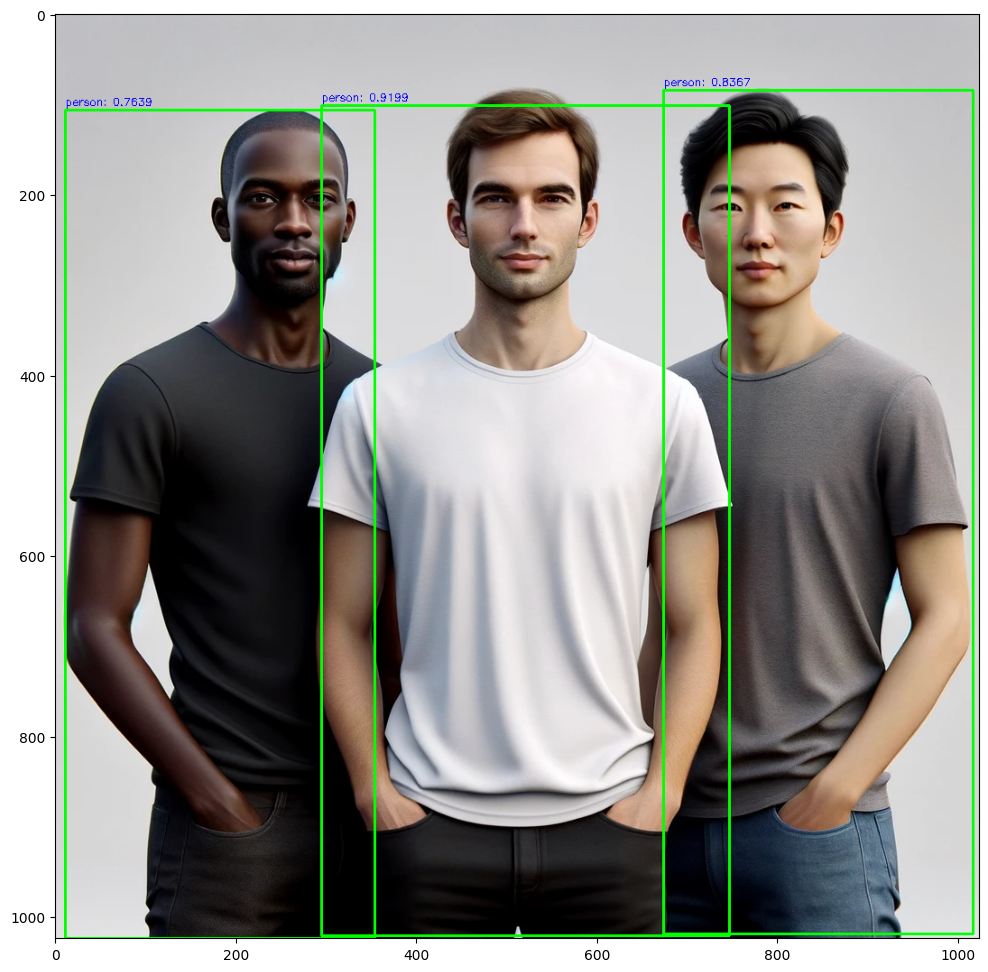

In [ ]:
img_array = cv2.cvtColor(cv2.imread('test_image.png'), cv2.COLOR_BGR2RGB)
processed_img = detect_objects(model, img_array, 0.3, 100, True)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
plt.imshow(processed_img)